In [27]:
from MVT_funcyz import * 

In [28]:
# T90 and Tpre values from Coppin 
Tvals = pd.read_excel("may_work.xlsx")
Tpre = Tvals[['GRB', 'Tpre_min', 'Tpre_max', 'Tpre_duration']]
Tpre = Tpre.rename(columns={'Tpre_min': 'Tmin', 'Tpre_max': 'Tmax'})
T90_cop = Tvals[['GRB', 'T90_min', 'T90_max', 'T90_error']]
T90_cop = T90_cop.rename(columns={'T90_min' : 'Tmin', 'T90_max' : 'Tmax', 'T90_error' : 'Terr'})

# T90 values from the Fermi GRB catalog 
T90_cat = pd.read_csv('T90_catalog.txt', sep='|')
T90_cat.drop(['Unnamed: 0', 'Unnamed: 5'], axis=1, inplace=True)
T90_cat.iloc[:, 1:] = T90_cat.iloc[:, 1:].astype(float)
T90_cat['Tmax'] = T90_cat['Tmin'] + T90_cat['t90_duration']

# Match up Swift and Fermi names for Coppin precusor sample 
temp = pd.read_csv('../temp_names.csv')
temp.drop(['Unnamed: 0'], axis=1, inplace=True)
T90_c = T90_cat.merge(temp, on='GRB_name_Fermi', how='inner')

Coppin_GRBs, Coppin_fname = GRBS_in_folder(folder_name='coppin_lgrbs', file_suffix='.lc')
MVT_DF = MVTDataFrame('coppin_grbs.csv')

T90 = T90_c
T90

,GRB_name_Fermi,t90_duration,Terr,Tmin,Tmax,GRB
0,GRB190806675,20.992,2.374,0.320,21.312,GRB190806A
1,GRB160919613,62.465,3.665,-9.728,52.737,GRB160919A
2,GRB160919613,62.465,3.665,-9.728,52.737,GRB160919A
3,GRB090810659,125.182,1.846,0.004,125.186,GRB090810A
4,GRB130320560,340.992,1.619,-138.240,202.752,GRB130320B
...,...,...,...,...,...,...
239,GRB120513531,23.808,0.923,-0.512,23.296,GRB120513A
240,GRB090618353,112.386,1.086,7.936,120.322,GRB090618A
241,GRB120530121,77.054,1.810,0.003,77.057,GRB120530A
242,GRB140404030,84.992,5.910,-72.704,12.288,GRB140404A


In [29]:
#  Remove LCs where data does not extend into Tpre 
no_data_name = []
no_data_fname = []
for row, (GRB_name, fname) in enumerate(zip(Coppin_GRBs, Coppin_fname)):
    
    TPre_min, TPre_max, _ = get_Tmin_Tmax(GRB_name, Tpre)
    GRB = read_fermi_fits_file(filename=f'coppin_lgrbs/{fname}', Tmin=-500, Tmax=500)
    if GRB.TIME[0] > TPre_min:
        no_data_name.append(GRB_name)
        no_data_fname.append(fname)

print(len(no_data_name), len(no_data_fname))
Coppin_GRBs = [name for name in Coppin_GRBs if name not in no_data_name]
Coppin_fname = [name for name in Coppin_fname if name not in no_data_fname]
print(len(Coppin_GRBs))

59 59
152


In [30]:
# remove LCs where MVT already found 
grbs_done = [] 
fname_done = [] 
for (GRB_name, fname) in zip(Coppin_GRBs, Coppin_fname):
    if GRB_name in MVT_DF.get_grbs_done():
        grbs_done.append(GRB_name)
        fname_done.append(fname)

Coppin_GRBs = [name for name in Coppin_GRBs if name not in grbs_done]
Coppin_fname = [name for name in Coppin_fname if name not in fname_done]

print(f'{len(grbs_done)} GRBs done')
print(f'{len(Coppin_GRBs)} GRBs remaining')
Coppin_GRBs = [name for name in Coppin_GRBs if name not in no_data_name]
Coppin_fname = [name for name in Coppin_fname if name not in no_data_fname]


0 GRBs done
152 GRBs remaining


In [31]:
# Sort GRBs by smallest Tpre duration to largest  
sorted_Tpre = Tpre.sort_values(by='Tpre_duration', ascending=True)
Coppin_GRBs_dupe = Coppin_GRBs
Coppin_fname_dupe = Coppin_fname
Coppin_GRBs = [name for name in sorted_Tpre['GRB'] if name in Coppin_GRBs_dupe]
Coppin_fname = [name for partial in sorted_Tpre['GRB'] for name in Coppin_fname_dupe if partial in name]

//////////////////////////////////////////////////////////// GRB150703A ////////////////////////////////////////////////////////////
5.152
------------------------------------------------------------ T90 ------------------------------------------------------------


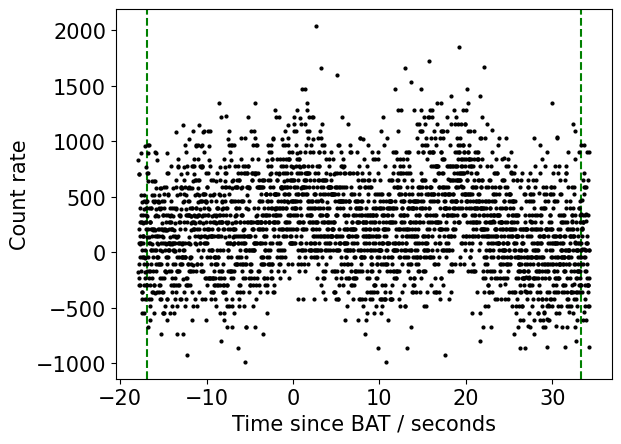

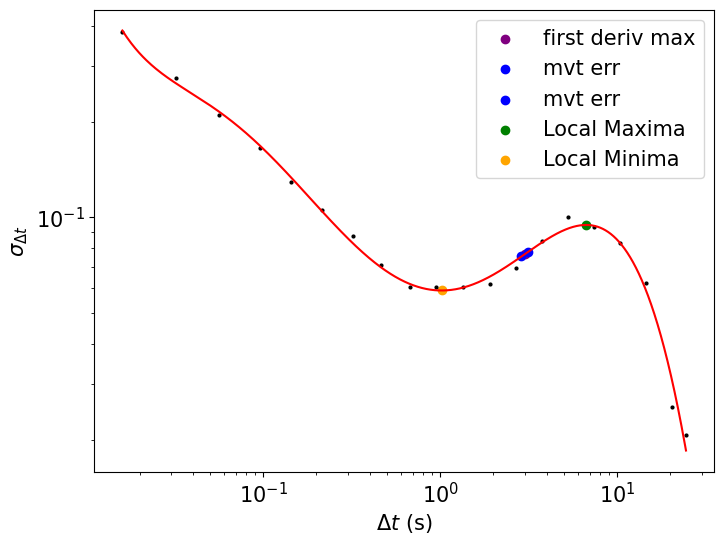

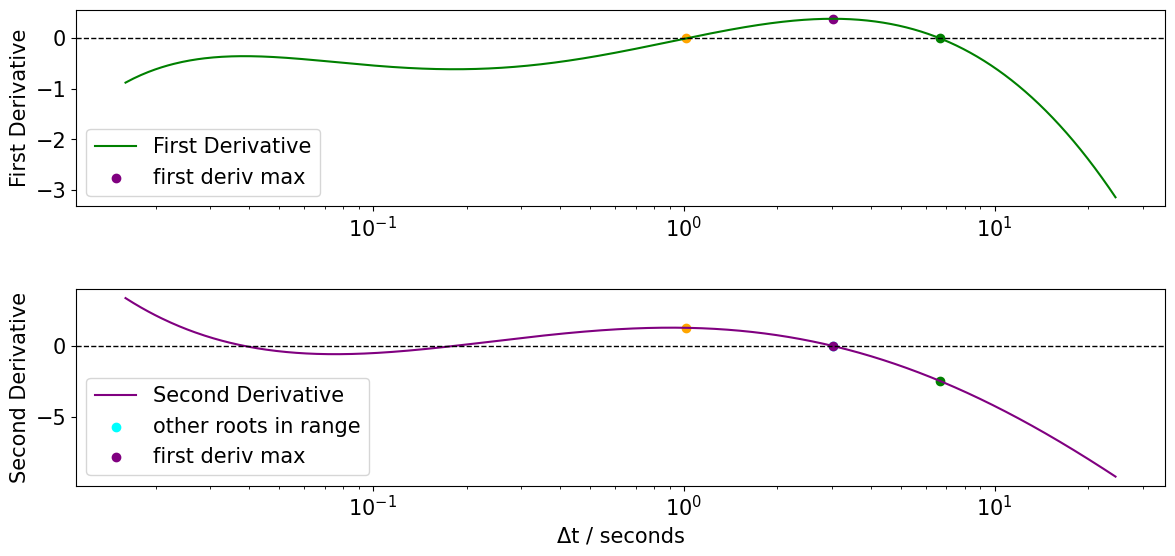

mvt: 3.0117368762996977 +- 0.13163527241543838
------------------------------------------------------------ Tpre ------------------------------------------------------------


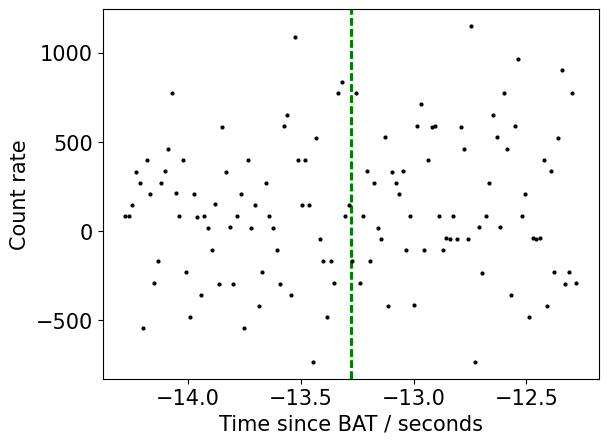

Error occurred while processing GRB GRB150703A: Length mismatch: Expected axis has 0 elements, new values have 2 elements


In [32]:
# Calcuate MVT 
for row, (GRB_name, fname) in enumerate(zip(Coppin_GRBs, Coppin_fname), start=len(MVT_DF.get_dataframe())):
    
    print_banner(GRB_name)
    T90_min, T90_max, T90_err = get_Tmin_Tmax(GRB_name, T90)
    TPre_min, TPre_max, _ = get_Tmin_Tmax(GRB_name, Tpre)
    print(T90_err)

    for Tx in ['T90', 'Tpre']:

        print_banner(Tx, '-')

        Tmin, Tmax = (T90_min, T90_max) if Tx == 'T90' else (TPre_min, TPre_max)
        scale = 1
        refine = Refine(Tmin=Tmin, Tmax=Tmax, scale=scale, degree=6, multiplier=1.4)
        
        repeat = True 
        while repeat: 

            GRB = read_fermi_fits_file(filename=f'coppin_lgrbs/{fname}', Tmin=refine.Tmin - scale, Tmax=refine.Tmax + scale)
            plot_func(data=GRB, x_axis='TIME', y_axis='RATE', Sig_or_LC='LC', window_size=1,  t90=[refine.Tmin, refine.Tmax])

            GRB = GRB[(GRB['TIME'] > refine.Tmin) & (GRB['TIME'] < refine.Tmax)]
            GRB.reset_index(drop=True, inplace=True)

            try: 
                sigma_values = calc_sigma(curve=GRB, bin_width=16, scale=refine.scale)
                average_sigma = actual_avg(sigma_values=sigma_values, multiplier=refine.multiplier)
                local_minima, local_maxima, poly = fit_poly(data=average_sigma, x_axis='delta_t', y_axis='sigma_avg', degree=refine.degree, plot=False)
                refine.assign_stationairy(local_minima, local_maxima)
                mvt, mvterr = plot_second_derivative_errors(data=average_sigma, x_axis='delta_t', y_axis='sigma_avg', local_minima=refine.local_min, local_maxima=refine.local_max, poly=poly, degree=refine.degree)
                MVT_DF.add_row(row=row, grb=GRB_name, col_name=[Tx, mvt, mvterr, (Tmax - Tmin), T90_err])

            except Exception as e:
                print(f"Error occurred while processing GRB {GRB_name}: {e}")

            repeat = refine.repeat(row=row, mvtClass=MVT_DF, Tx=Tx)


In [33]:
MVT_DF.get_dataframe()

,GRB,T90_duration,T90_duration_err,T90_MVT,T90_MVT_err,Tpre_MVT,Tpre_MVT_err,Tpre_duration
0,GRB150703A,50.176,5.152,3.011737,0.131635,NaN,NaN,NaN


In [34]:
# Plot Tpres 
# for row, (GRB_name, fname) in enumerate(zip(Coppin_GRBs, Coppin_fname), start=len(MVT_DF.get_dataframe())):
    
#     print_banner(GRB_name)
#     T90_min, T90_max, T90_err = get_Tmin_Tmax(GRB_name, T90)
#     TPre_min, TPre_max, _ = get_Tmin_Tmax(GRB_name, Tpre)
#     print(T90_err)

#     for Tx in ['T90', 'Tpre']:

#         if Tx == 'T90':
#             continue 

#         print_banner(Tx, '-')

#         Tmin, Tmax = (T90_min, T90_max) if Tx == 'T90' else (TPre_min, TPre_max)
#         scale = 5
#         refine = Refine(Tmin=Tmin, Tmax=Tmax, scale=scale, degree=6, multiplier=1.4)


#         GRB = read_fermi_fits_file(filename=f'coppin_lgrbs/{fname}', Tmin=refine.Tmin - scale, Tmax=refine.Tmax + scale)
#         plot_func(data=GRB, x_axis='TIME', y_axis='RATE', Sig_or_LC='LC', window_size=4,  t90=[refine.Tmin, refine.Tmax])

#         GRB = GRB[(GRB['TIME'] > refine.Tmin) & (GRB['TIME'] < refine.Tmax)]
#         GRB.reset_index(drop=True, inplace=True)